In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Plot utils

In [2]:
def plot_scatter(x, y, centres=None):
  fig = plt.figure(figsize=(10,10))
  plt.scatter(x[:,0], x[:,1], c=y, alpha=0.7, s=10);

  if centres is not None:
    n_centres = len(centres)
    for i, c in enumerate(centres):
      plt.scatter(c[:,0], c[:,1], c=np.arange(c.shape[0]), marker='*', s=500, alpha=(i+1)/n_centres)
  plt.show();

def plot_scatter_history(x, clusters_hist, centres_hist=None):
  iters = len(clusters_hist)
  assert len(clusters_hist) == len(centres_hist)

  fig_n_cols = 4
  fig_n_rows = (iters // 4) + 1

  plt.figure(figsize=(8 * fig_n_cols, 8 * fig_n_rows))
  for i in range(iters):
    plt.subplot(fig_n_rows, fig_n_cols, i+1)
    plt.scatter(x[:,0], x[:,1], c=clusters_hist[i], alpha=0.7, s=10);
    plt.scatter(centres_hist[i][:,0], centres_hist[i][:,1], c=np.arange(len(centres_hist[0])), marker='*', s=500)
    plt.title(f'iteration {i}')
  plt.show();

# Score and cost calculation

In [3]:
def purity_cost(y, clusters):
  n_clusters = len(set(y))
  clusters_purity = []
  for c1 in range(n_clusters):
    one_class_putiry = []
    for c2 in range(n_clusters):
      one_class_putiry.append(np.sum((clusters == c1) & (y == c2)))
    clusters_purity.append(np.max(one_class_putiry))
  return np.sum(clusters_purity) / len(y)

def calc_purity_hist(y, clusters_hist):
  purity_hist = []
  for c in clusters_hist:
    purity_hist.append(purity_cost(y, c))
  return purity_hist

In [4]:
def davis_bouldin_index_cost(x, clusters, cluster_centres, dist_calc_func):
  K = len(cluster_centres)
  sigma = np.zeros(K)
  for k in range(K):
    d = dist_calc_func(x[clusters == k] - cluster_centres[k])
    sigma[k] = np.sqrt(d.mean())
  
  clusters_divergence = []
  for i in range(K):
    one_class_divergence = []
    for j in range(K):
      if i != j:
        dc = np.sqrt(dist_calc_func(cluster_centres[i] - cluster_centres[j]))
        one_class_divergence.append((sigma[i] + sigma[j]) / dc)
    clusters_divergence.append(np.max(one_class_divergence))
  return np.mean(clusters_divergence)

def calc_davis_bouldin_index_hist(x, clusters_hist, centres_hist, dist_calc_func):
  index_hist = []
  for i in range(len(clusters_hist)):
    index_hist.append(davis_bouldin_index_cost(x, clusters_hist[i], centres_hist[i], dist_calc_func))
  return index_hist

# Means algorithm

In [5]:
def find_centres(x, y):
  assert x.shape[0] == y.shape[0]

  n_classes = len(set(y))
  mu = np.zeros((n_classes, *X.shape[1:]))
  for k in range(n_classes):
    mu[k,:] = x[y == k].mean(axis=0)
  return mu

norm_vec = np.vectorize(lambda x: x.dot(x), signature='(d)->()')

def assign_clusters(x, centres):
  assert x.shape[1:] == centres.shape[1:]
  N = x.shape[0]
  D = x.shape[1]
  K = centres.shape[0]

  d = np.zeros((N, K))
  for c in range(centres.shape[0]):
    diff = x - centres[c]
    d[:,c] = norm_vec(diff)
    
  clossest_centre = d.argmin(axis=1)
  cost = d[np.arange(N), clossest_centre].sum()

  return clossest_centre, cost

def k_means_step(x, centres):
  new_clusters, cost = assign_clusters(x, centres)
  new_centres = find_centres(x, new_clusters)
  return new_clusters, new_centres, cost

def k_means_hard(x, initial_centres, max_steps=None, logging_step=None):
  assert x.shape[1] == initial_centres.shape[1]

  centres_hist = [initial_centres]
  clusters_hist = []
  cost_hist = []
  step = 0
  while True:
    if logging_step is not None and step % logging_step == 0:
      print('step:', step)
    if max_steps is not None and step > max_steps:
      print(f'early stop after {step+1} steps - reached maximum number of steps')
      break
    new_clusters, new_centres, cost = k_means_step(x, centres_hist[-1])
    clusters_hist.append(new_clusters)
    centres_hist.append(new_centres)
    cost_hist.append(cost)

    if step > 1 and np.array_equal(prev_clusters, new_clusters):
      print(f'early stop after {step+1} steps - assigned clusters has not changed')
      break
          
    prev_clusters = new_clusters
    step += 1
  
  return clusters_hist, centres_hist, cost_hist

# Load data

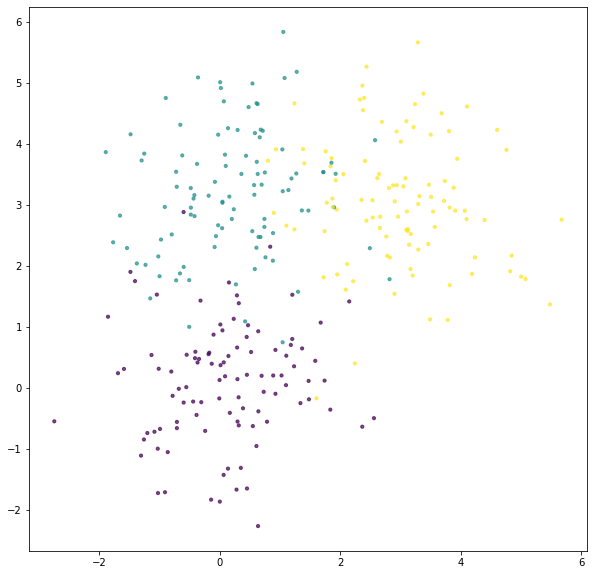

In [6]:
N = 300
D = 2
K = 3
shift = 3

mu0 = np.array([0,0])
mu1 = np.array([0,shift])
mu2 = np.array([shift,shift])

X = np.random.randn(N, D)
X[:100] += mu0
X[100:200] += mu1
X[200:] += mu2

y = np.array([0] * 100 + [1] * 100 + [2] * 100)

ids = np.arange(N)
np.random.shuffle(ids)
X = X[ids]
y = y[ids]

plot_scatter(X, y)

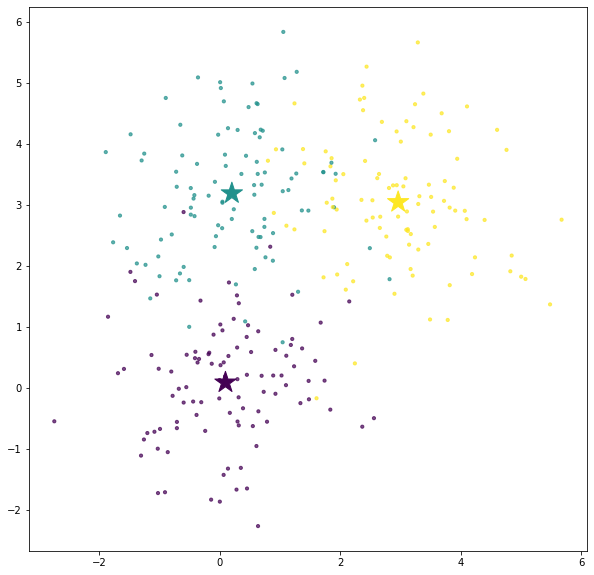

In [7]:
mu0 = find_centres(X, y)
plot_scatter(X, y, [mu0])

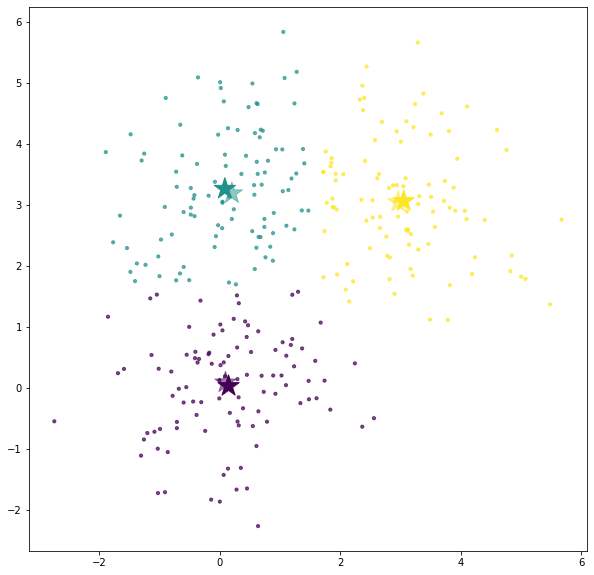

In [8]:
new_clusters, _ = assign_clusters(X, mu0)
mu1 = find_centres(X, new_clusters)

plot_scatter(X, new_clusters, [mu0, mu1])

# Kmeans on genereated data

step: 0
step: 10
early stop after 12 steps - assigned clusters has not changed


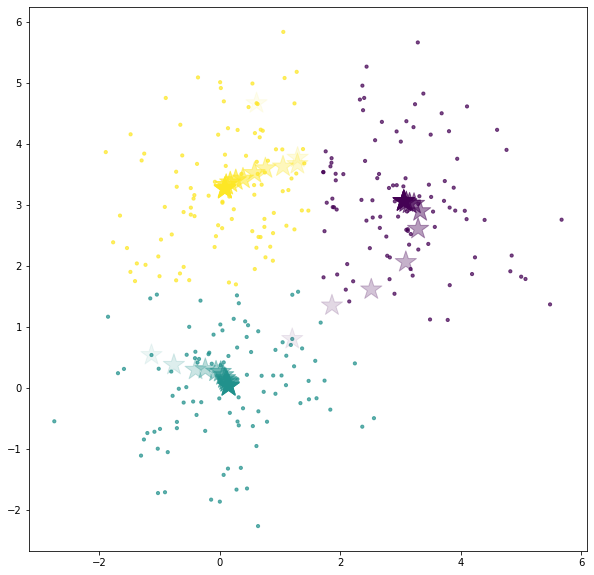

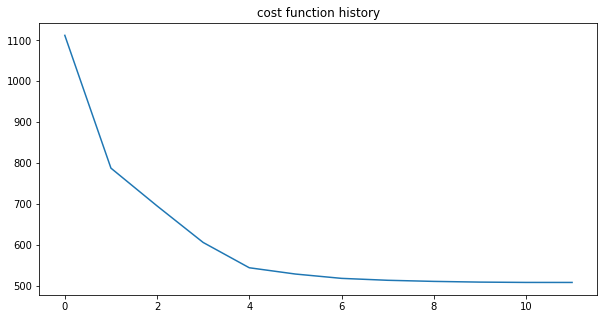

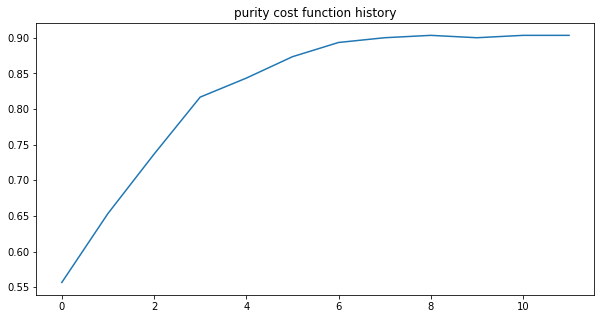

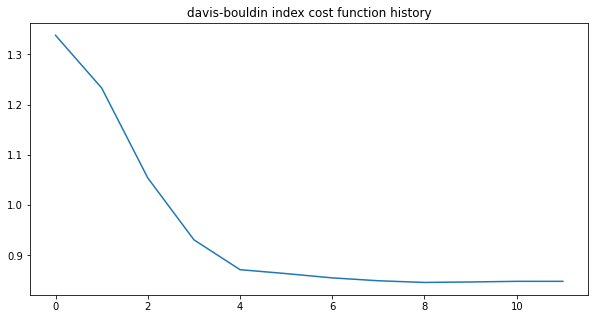

In [9]:
shuffle_ids = np.arange(N)
np.random.shuffle(shuffle_ids)
centres0 = X[shuffle_ids[:3]]

clusters_hist, centres_hist, cost_hist = k_means_hard(X, centres0, max_steps=100, logging_step=10)
plot_scatter(X, clusters_hist[-1], centres_hist)

plt.figure(figsize=(10,5))
plt.plot(cost_hist)
plt.title('cost function history');

purity_hist = calc_purity_hist(y, clusters_hist)
plt.figure(figsize=(10,5))
plt.plot(purity_hist)
plt.title('purity cost function history')
plt.show();

purity_hist = calc_davis_bouldin_index_hist(X, clusters_hist, centres_hist[1:], norm_vec)
plt.figure(figsize=(10,5))
plt.plot(purity_hist)
plt.title('davis-bouldin index cost function history')
plt.show();

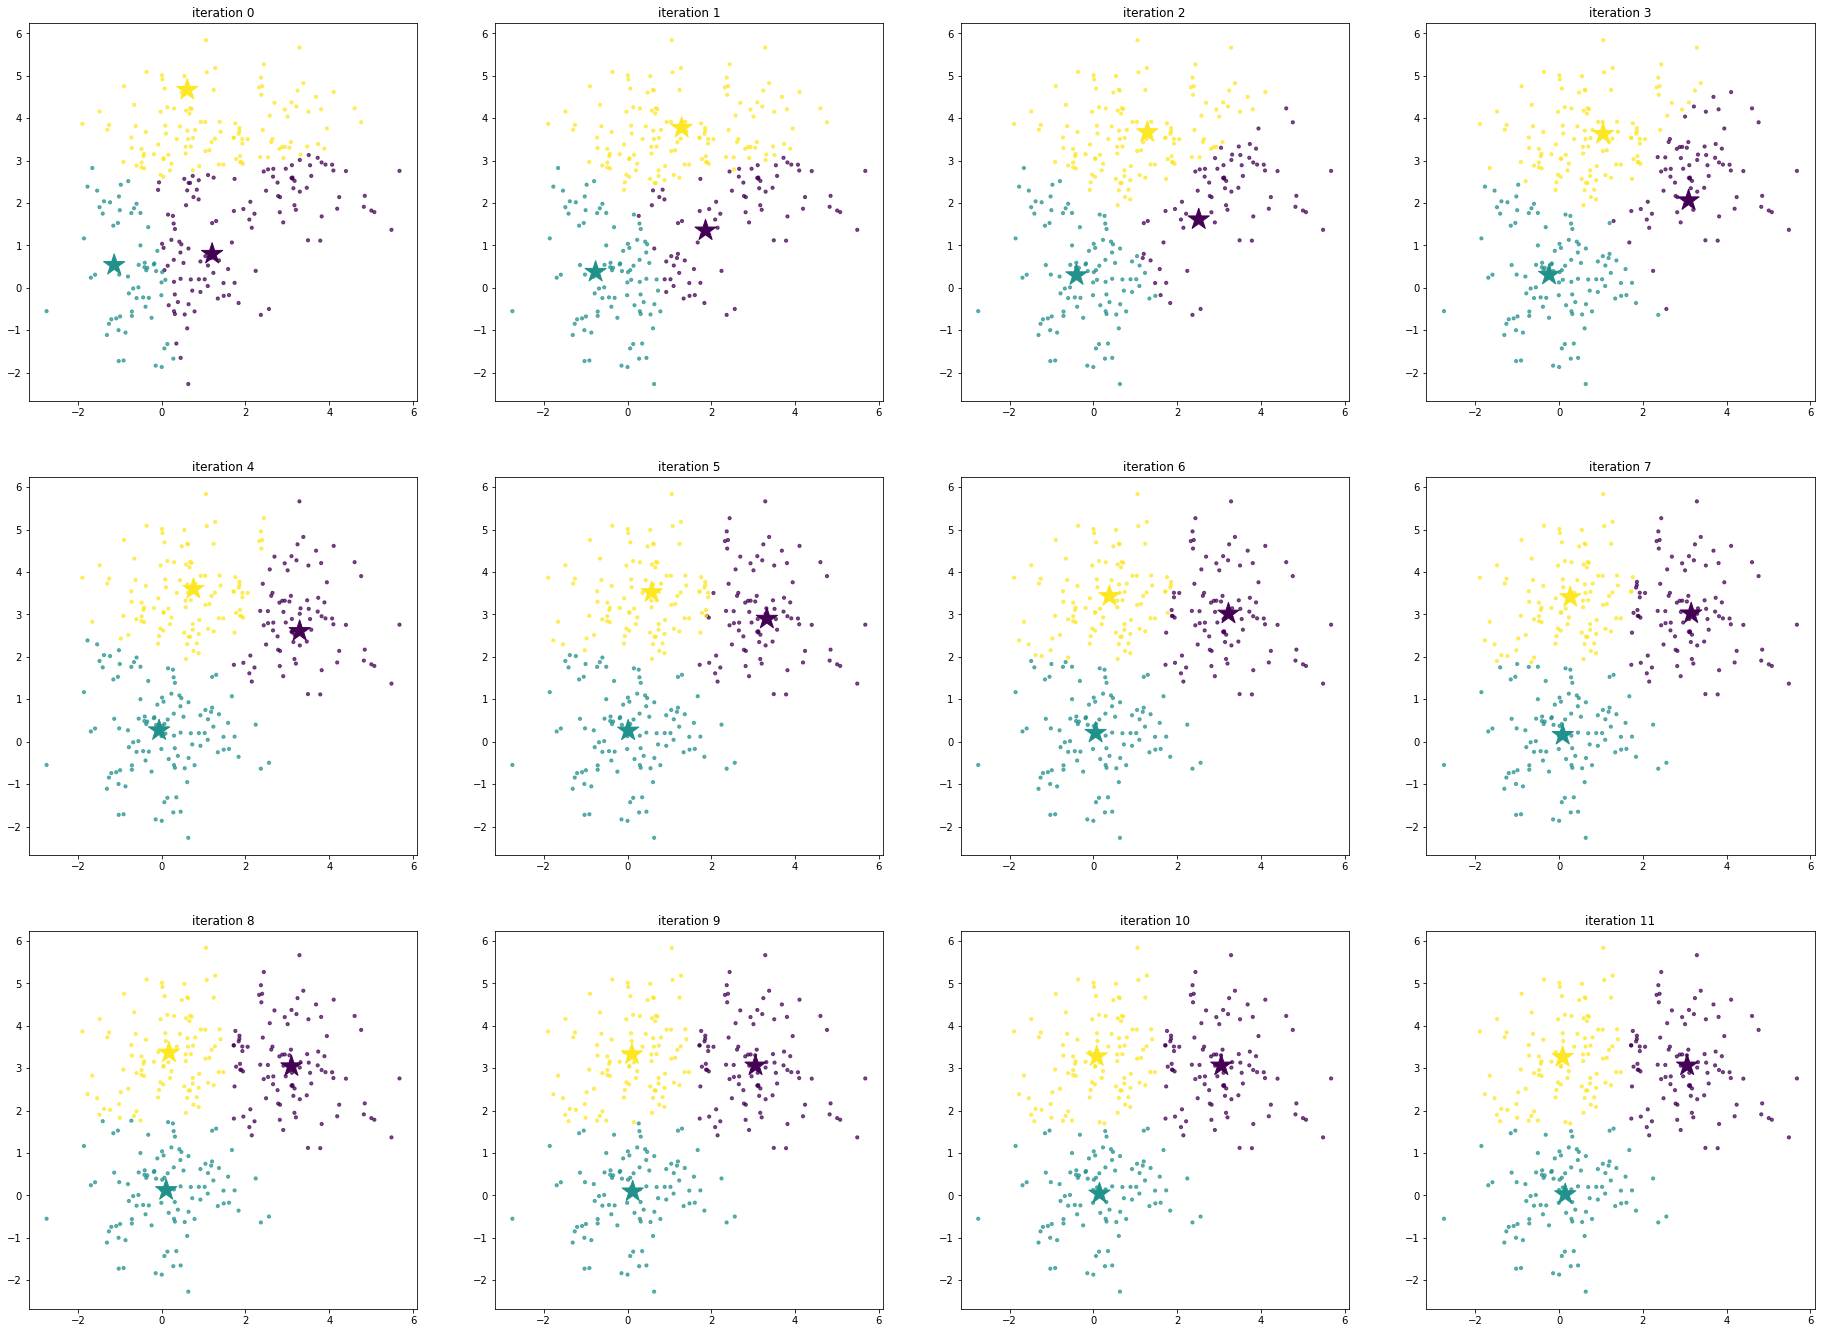

In [10]:
plot_scatter_history(X, clusters_hist, centres_hist[:-1])